<a href="https://colab.research.google.com/github/linhlinhle997/vae-mnist/blob/develop/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision

In [ ]:
import os
from datetime import datetime

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


## Load Dataset

In [ ]:
batch_size = 256
img_size = 28 # original image size is 28x28

In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 527kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.65MB/s]


Split dataset - training (80%) - validation (20%)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 48000
Validation samples: 12000


Create DataLoaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

Number of batches in training loader: 188
Number of batches in validation loader: 47


## VAE Model
- **Encoder**: Transforms the input image into a lower-dimensional latent space.
- **Reparameterization**: Generates random variables from the latent space following a standard distribution.
- **Decoder**: Converts the latent space back into the original image using transposed convolutional layers.
- **Forward Function**: Directs the flow of data through each component of the model.

In [ ]:
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)

        self.flatten_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(in_features=self.flatten_dim, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=self.flatten_dim, out_features=latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(in_features=latent_dim, out_features=self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x)) # [batch_size, 1, 28, 28] -> [batch_size, 16, 28, 28]
        x = F.relu(self.conv2(x)) # [batch_size, 16, 28, 28] -> [batch_size, 32, 14, 14]
        x = F.relu(self.conv3(x)) # [batch_size, 32, 14, 14] -> [batch_size, 64, 7, 7]
        x = x.view(-1, self.flatten_dim) # [batch_size, 64, 7, 7] -> [batch_size, 64*7*7]
        mu = self.fc_mu(x) # [batch_size, 64*7*7] -> [batch_size, latent_dim]
        logvar = self.fc_logvar(x) # [batch_size, 64*7*7] -> [batch_size, latent_dim]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # Compute standard deviation from log variance.
        eps = torch.randn_like(std) # Sample from a standard normal distribution.
        return mu + eps * std # Reparameterization trick: z = mu + std * eps.

    def decode(self, z):
        x = F.relu(self.fc_decode(z))  # [batch_size, latent_dim] -> [batch_size, 64*7*7]
        x = x.view(-1, 64, 7, 7) # [batch_size, 64*7*7] -> [batch_size, 64, 7, 7]
        x = F.relu(self.deconv1(x)) # [batch_size, 64, 7, 7] -> [batch_size, 32, 14, 14]
        x = F.relu(self.deconv2(x)) # [batch_size, 32, 14, 14] -> [batch_size, 16, 28, 28]
        x = torch.sigmoid(self.conv_final(x)) # [batch_size, 16, 28, 28] -> [batch_size, 1, 28, 28]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x) # Encode input image into latent space parameters.
        z = self.reparameterize(mu, logvar) # Sample from the latent space.
        recon_x = self.decode(z) # Decode the latent vector back to image space.
        return recon_x, mu, logvar # Return reconstructed image and latent parameters.

### Loss
The loss function in VAE consists of two components:
- **Reconstruction Loss**: Measures the difference between the input image and the reconstructed image using Mean Squared Error (MSE).

- **KL Divergence (KL Loss)**: Regularizes the latent distribution towards a standard normal distribution, helping the model generate more realistic data.

- **Total Loss**: Combines both components, where the reconstruction loss is multiplied by a coefficient B to balance its impact.

In [ ]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B * recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + kl_loss.mean()

    return total_loss, reconstruction_loss, kl_loss.mean()

### Initialize Model and Optimizer

In [ ]:
num_epochs = 200
channels = 1 # grayscale image
latent_dim = 2

model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Train model

In [ ]:
# Create a log directory if it does not exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total_epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

In [ ]:
def train_model(model, optimizer, train_loader, num_epochs, device):
    avg_losses, recon_losses, kl_losses = [], [], []

    model.train()
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

        for data, _ in epoch_bar:
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            epoch_bar.set_postfix(loss=loss.item())

        # Caculate average loss
        avg_loss = train_loss / len(train_loader.dataset)

        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Loss: {avg_loss:.6f}, Recon Loss: {recon_loss.item():.6f}, KL Loss: {kl_loss.item():.6f}"
        )

        avg_losses.append(avg_loss)
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        # Save loss to log file
        with open(log_file, "a") as f:
            f.write(f"{epoch},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

    print(f"Training log saved to {log_file}")
    return avg_losses, recon_losses, kl_losses

In [13]:
avg_losses, recon_losses, kl_losses = train_model(
    model,
    optimizer,
    train_loader,
    num_epochs,
    device
)

Epoch 1/200: Loss: 353.122629, Recon Loss: 56.699577, KL Loss: 6.337510


Epoch 2/200: Loss: 186.507016, Recon Loss: 45.428871, KL Loss: 11.601055


Epoch 3/200: Loss: 164.828781, Recon Loss: 42.223053, KL Loss: 11.790714


Epoch 4/200: Loss: 155.327349, Recon Loss: 40.840286, KL Loss: 12.393272


Epoch 5/200: Loss: 150.716994, Recon Loss: 39.443024, KL Loss: 12.759697


Epoch 6/200: Loss: 147.728345, Recon Loss: 37.700661, KL Loss: 13.270448


Epoch 7/200: Loss: 145.408409, Recon Loss: 36.232834, KL Loss: 13.772136


Epoch 8/200: Loss: 143.240763, Recon Loss: 36.723175, KL Loss: 13.833275


Epoch 9/200: Loss: 141.030918, Recon Loss: 35.064819, KL Loss: 13.792791


Epoch 10/200: Loss: 139.898879, Recon Loss: 37.349339, KL Loss: 13.405333


Epoch 11/200: Loss: 138.515816, Recon Loss: 37.525009, KL Loss: 13.509074


Epoch 12/200: Loss: 137.280349, Recon Loss: 35.043655, KL Loss: 13.788460


Epoch 13/200: Loss: 136.422732, Recon Loss: 35.833263, KL Loss: 14.929339


Epoch 14/200: Loss: 135.620189, Recon Loss: 34.783928, KL Loss: 14.461881


Epoch 15/200: Loss: 134.696656, Recon Loss: 33.576645, KL Loss: 14.525403


Epoch 16/200: Loss: 134.117066, Recon Loss: 34.798477, KL Loss: 14.602581


Epoch 17/200: Loss: 133.311853, Recon Loss: 34.380859, KL Loss: 14.461733


Epoch 18/200: Loss: 132.816021, Recon Loss: 31.122128, KL Loss: 14.875875


Epoch 19/200: Loss: 132.190080, Recon Loss: 33.905521, KL Loss: 14.667200


Epoch 20/200: Loss: 131.758673, Recon Loss: 33.802444, KL Loss: 15.597809


Epoch 21/200: Loss: 131.308565, Recon Loss: 33.504234, KL Loss: 15.019550


Epoch 22/200: Loss: 130.852132, Recon Loss: 31.113916, KL Loss: 15.028293


Epoch 23/200: Loss: 130.478212, Recon Loss: 33.672752, KL Loss: 15.431384


Epoch 24/200: Loss: 130.357316, Recon Loss: 34.151279, KL Loss: 14.182920


Epoch 25/200: Loss: 129.767411, Recon Loss: 32.991833, KL Loss: 14.406374


Epoch 26/200: Loss: 129.378653, Recon Loss: 32.694630, KL Loss: 15.233732


Epoch 27/200: Loss: 129.117797, Recon Loss: 31.819466, KL Loss: 15.982544


Epoch 28/200: Loss: 128.661742, Recon Loss: 31.343531, KL Loss: 15.675872


Epoch 29/200: Loss: 128.640030, Recon Loss: 31.348732, KL Loss: 14.802804


Epoch 30/200: Loss: 128.166233, Recon Loss: 32.583298, KL Loss: 15.575628


Epoch 31/200: Loss: 127.851192, Recon Loss: 33.921883, KL Loss: 14.966791


Epoch 32/200: Loss: 127.800185, Recon Loss: 31.368198, KL Loss: 15.882705


Epoch 33/200: Loss: 127.632630, Recon Loss: 33.384045, KL Loss: 14.519146


Epoch 34/200: Loss: 127.258024, Recon Loss: 34.001812, KL Loss: 15.799850


Epoch 35/200: Loss: 126.825624, Recon Loss: 34.026802, KL Loss: 15.982121


Epoch 36/200: Loss: 126.589591, Recon Loss: 32.528641, KL Loss: 15.221956


Epoch 37/200: Loss: 126.549009, Recon Loss: 30.573397, KL Loss: 15.499549


Epoch 38/200: Loss: 126.189315, Recon Loss: 29.920918, KL Loss: 15.699045


Epoch 39/200: Loss: 126.152471, Recon Loss: 33.777916, KL Loss: 15.098576


Epoch 40/200: Loss: 126.112412, Recon Loss: 32.489365, KL Loss: 15.234104


Epoch 41/200: Loss: 125.860574, Recon Loss: 32.248600, KL Loss: 15.667122


Epoch 42/200: Loss: 125.540350, Recon Loss: 35.382404, KL Loss: 15.498375


Epoch 43/200: Loss: 125.407570, Recon Loss: 30.789482, KL Loss: 15.714814


Epoch 44/200: Loss: 125.348617, Recon Loss: 33.031601, KL Loss: 15.275968


Epoch 45/200: Loss: 124.842494, Recon Loss: 30.890720, KL Loss: 14.871814


Epoch 46/200: Loss: 124.828243, Recon Loss: 32.999771, KL Loss: 14.608069


Epoch 47/200: Loss: 124.940722, Recon Loss: 31.674019, KL Loss: 15.505808


Epoch 48/200: Loss: 124.992288, Recon Loss: 31.285450, KL Loss: 15.765836


Epoch 49/200: Loss: 124.194095, Recon Loss: 29.303177, KL Loss: 15.216635


Epoch 50/200: Loss: 124.383094, Recon Loss: 34.663422, KL Loss: 14.838926


Epoch 51/200: Loss: 124.181118, Recon Loss: 33.415470, KL Loss: 15.416456


Epoch 52/200: Loss: 124.073808, Recon Loss: 31.485594, KL Loss: 15.723184


Epoch 53/200: Loss: 123.694083, Recon Loss: 30.924780, KL Loss: 16.203413


Epoch 54/200: Loss: 123.661654, Recon Loss: 31.415005, KL Loss: 15.664541


Epoch 55/200: Loss: 123.666176, Recon Loss: 31.494118, KL Loss: 16.161806


Epoch 56/200: Loss: 123.498365, Recon Loss: 31.791615, KL Loss: 14.710469


Epoch 57/200: Loss: 123.386966, Recon Loss: 30.898647, KL Loss: 16.471949


Epoch 58/200: Loss: 123.508953, Recon Loss: 33.283352, KL Loss: 15.477925


Epoch 59/200: Loss: 123.254658, Recon Loss: 31.473358, KL Loss: 15.794271


Epoch 60/200: Loss: 123.151841, Recon Loss: 32.334698, KL Loss: 15.733223


Epoch 61/200: Loss: 122.796235, Recon Loss: 30.796909, KL Loss: 16.210947


Epoch 62/200: Loss: 122.898241, Recon Loss: 32.538490, KL Loss: 15.014584


Epoch 63/200: Loss: 122.698059, Recon Loss: 31.508728, KL Loss: 15.928863


Epoch 64/200: Loss: 122.564824, Recon Loss: 33.156284, KL Loss: 16.097742


Epoch 65/200: Loss: 122.558965, Recon Loss: 30.495241, KL Loss: 15.019781


Epoch 66/200: Loss: 122.305573, Recon Loss: 33.567142, KL Loss: 15.643419


Epoch 67/200: Loss: 122.214498, Recon Loss: 31.218147, KL Loss: 16.540644


Epoch 68/200: Loss: 122.427780, Recon Loss: 32.300770, KL Loss: 15.365647


Epoch 69/200: Loss: 122.146870, Recon Loss: 31.920210, KL Loss: 16.304153


Epoch 70/200: Loss: 121.860173, Recon Loss: 29.362261, KL Loss: 16.477825


Epoch 71/200: Loss: 122.024448, Recon Loss: 32.790970, KL Loss: 16.103197


Epoch 72/200: Loss: 121.741458, Recon Loss: 29.800198, KL Loss: 17.152681


Epoch 73/200: Loss: 121.726956, Recon Loss: 30.675753, KL Loss: 18.569134


Epoch 74/200: Loss: 121.644041, Recon Loss: 31.352390, KL Loss: 16.150732


Epoch 75/200: Loss: 121.552198, Recon Loss: 31.327543, KL Loss: 16.336977


Epoch 76/200: Loss: 121.500799, Recon Loss: 31.810574, KL Loss: 16.520569


Epoch 77/200: Loss: 121.411910, Recon Loss: 32.569717, KL Loss: 14.377556


Epoch 78/200: Loss: 121.409528, Recon Loss: 30.509342, KL Loss: 16.416945


Epoch 79/200: Loss: 121.184197, Recon Loss: 32.186367, KL Loss: 15.829812


Epoch 80/200: Loss: 121.111091, Recon Loss: 30.381714, KL Loss: 15.716882


Epoch 81/200: Loss: 121.021969, Recon Loss: 31.327913, KL Loss: 16.364351


Epoch 82/200: Loss: 120.953121, Recon Loss: 31.312635, KL Loss: 16.126503


Epoch 83/200: Loss: 120.762319, Recon Loss: 31.061184, KL Loss: 15.454083


Epoch 84/200: Loss: 120.771730, Recon Loss: 29.860163, KL Loss: 17.230120


Epoch 85/200: Loss: 120.706816, Recon Loss: 29.762383, KL Loss: 16.912783


Epoch 86/200: Loss: 120.725345, Recon Loss: 29.585644, KL Loss: 16.524622


Epoch 87/200: Loss: 120.756095, Recon Loss: 32.978851, KL Loss: 16.063702


Epoch 88/200: Loss: 120.725218, Recon Loss: 30.620728, KL Loss: 16.475443


Epoch 89/200: Loss: 120.418094, Recon Loss: 30.337107, KL Loss: 16.742357


Epoch 90/200: Loss: 120.342022, Recon Loss: 29.876606, KL Loss: 17.572826


Epoch 91/200: Loss: 120.578099, Recon Loss: 29.453510, KL Loss: 17.033474


Epoch 92/200: Loss: 120.128442, Recon Loss: 29.725887, KL Loss: 16.549685


Epoch 93/200: Loss: 120.148019, Recon Loss: 30.934082, KL Loss: 17.464701


Epoch 94/200: Loss: 120.153053, Recon Loss: 29.797798, KL Loss: 17.124508


Epoch 95/200: Loss: 119.980570, Recon Loss: 30.628805, KL Loss: 17.154076


Epoch 96/200: Loss: 119.970431, Recon Loss: 30.657894, KL Loss: 15.975238


Epoch 97/200: Loss: 120.125519, Recon Loss: 29.441120, KL Loss: 17.208063


Epoch 98/200: Loss: 119.938981, Recon Loss: 30.967964, KL Loss: 16.806204


Epoch 99/200: Loss: 119.925588, Recon Loss: 29.837772, KL Loss: 17.928127


Epoch 100/200: Loss: 119.739194, Recon Loss: 28.940226, KL Loss: 17.137800


Epoch 101/200: Loss: 119.744363, Recon Loss: 28.810589, KL Loss: 18.283764


Epoch 102/200: Loss: 119.536473, Recon Loss: 32.322189, KL Loss: 16.039690


Epoch 103/200: Loss: 119.659996, Recon Loss: 30.335915, KL Loss: 18.565323


Epoch 104/200: Loss: 119.486427, Recon Loss: 28.760826, KL Loss: 17.746668


Epoch 105/200: Loss: 119.584839, Recon Loss: 30.889542, KL Loss: 16.604074


Epoch 106/200: Loss: 119.456415, Recon Loss: 30.313288, KL Loss: 19.466242


Epoch 107/200: Loss: 119.526494, Recon Loss: 29.741552, KL Loss: 16.824614


Epoch 108/200: Loss: 119.574470, Recon Loss: 29.242371, KL Loss: 18.477079


Epoch 109/200: Loss: 119.269416, Recon Loss: 32.576370, KL Loss: 15.500117


Epoch 110/200: Loss: 119.260456, Recon Loss: 28.658741, KL Loss: 18.647100


Epoch 111/200: Loss: 119.128832, Recon Loss: 30.920383, KL Loss: 15.757051


Epoch 112/200: Loss: 118.931956, Recon Loss: 29.330051, KL Loss: 15.702138


Epoch 113/200: Loss: 119.096789, Recon Loss: 30.095562, KL Loss: 16.391232


Epoch 114/200: Loss: 119.016828, Recon Loss: 29.136822, KL Loss: 18.030191


Epoch 115/200: Loss: 119.110086, Recon Loss: 28.958065, KL Loss: 17.559868


Epoch 116/200: Loss: 118.918449, Recon Loss: 32.019917, KL Loss: 15.735735


Epoch 117/200: Loss: 118.929426, Recon Loss: 32.195503, KL Loss: 16.904642


Epoch 118/200: Loss: 118.908289, Recon Loss: 30.765751, KL Loss: 16.904354


Epoch 119/200: Loss: 118.741651, Recon Loss: 30.379997, KL Loss: 16.705534


Epoch 120/200: Loss: 118.767564, Recon Loss: 31.354733, KL Loss: 16.901581


Epoch 121/200: Loss: 118.875925, Recon Loss: 30.171486, KL Loss: 17.132296


Epoch 122/200: Loss: 118.694565, Recon Loss: 29.905220, KL Loss: 17.883369


Epoch 123/200: Loss: 118.655983, Recon Loss: 33.079079, KL Loss: 16.033689


Epoch 124/200: Loss: 118.395943, Recon Loss: 31.147690, KL Loss: 16.446589


Epoch 125/200: Loss: 118.515925, Recon Loss: 31.923174, KL Loss: 18.549120


Epoch 126/200: Loss: 118.525418, Recon Loss: 29.856071, KL Loss: 17.381205


Epoch 127/200: Loss: 118.389797, Recon Loss: 28.976372, KL Loss: 16.526628


Epoch 128/200: Loss: 118.361441, Recon Loss: 32.516102, KL Loss: 16.851063


Epoch 129/200: Loss: 118.296783, Recon Loss: 31.580526, KL Loss: 17.657948


Epoch 130/200: Loss: 118.592350, Recon Loss: 30.930088, KL Loss: 17.415144


Epoch 131/200: Loss: 118.276101, Recon Loss: 27.424015, KL Loss: 16.749395


Epoch 132/200: Loss: 118.219409, Recon Loss: 31.963402, KL Loss: 17.100647


Epoch 133/200: Loss: 118.184334, Recon Loss: 26.011250, KL Loss: 19.829695


Epoch 134/200: Loss: 118.001022, Recon Loss: 31.076992, KL Loss: 16.633587


Epoch 135/200: Loss: 118.044552, Recon Loss: 29.225338, KL Loss: 17.939156


Epoch 136/200: Loss: 118.198566, Recon Loss: 32.163914, KL Loss: 17.061586


Epoch 137/200: Loss: 118.077917, Recon Loss: 30.328287, KL Loss: 17.653999


Epoch 138/200: Loss: 118.069814, Recon Loss: 30.788342, KL Loss: 18.372881


Epoch 139/200: Loss: 118.067039, Recon Loss: 28.478085, KL Loss: 19.200964


Epoch 140/200: Loss: 117.990818, Recon Loss: 29.917707, KL Loss: 17.160208


Epoch 141/200: Loss: 117.852543, Recon Loss: 30.927658, KL Loss: 17.057333


Epoch 142/200: Loss: 117.917006, Recon Loss: 29.205853, KL Loss: 17.375196


Epoch 143/200: Loss: 117.867961, Recon Loss: 29.630745, KL Loss: 17.541660


Epoch 144/200: Loss: 117.806178, Recon Loss: 29.755941, KL Loss: 17.186443


Epoch 145/200: Loss: 117.741601, Recon Loss: 30.585831, KL Loss: 18.431957


Epoch 146/200: Loss: 117.755681, Recon Loss: 29.559761, KL Loss: 17.265402


Epoch 147/200: Loss: 117.786414, Recon Loss: 29.153625, KL Loss: 17.417524


Epoch 148/200: Loss: 117.608442, Recon Loss: 28.660736, KL Loss: 19.552668


Epoch 149/200: Loss: 117.626847, Recon Loss: 30.808619, KL Loss: 19.667978


Epoch 150/200: Loss: 117.475356, Recon Loss: 29.819014, KL Loss: 16.993256


Epoch 151/200: Loss: 117.413857, Recon Loss: 28.813690, KL Loss: 17.903967


Epoch 152/200: Loss: 117.485663, Recon Loss: 29.348099, KL Loss: 18.799877


Epoch 153/200: Loss: 117.660321, Recon Loss: 29.060604, KL Loss: 17.440243


Epoch 154/200: Loss: 117.572632, Recon Loss: 30.544420, KL Loss: 16.590216


Epoch 155/200: Loss: 117.634096, Recon Loss: 27.994503, KL Loss: 18.373936


Epoch 156/200: Loss: 117.421461, Recon Loss: 29.171768, KL Loss: 18.922184


Epoch 157/200: Loss: 117.441492, Recon Loss: 30.336485, KL Loss: 19.424984


Epoch 158/200: Loss: 117.440667, Recon Loss: 30.119617, KL Loss: 18.254234


Epoch 159/200: Loss: 117.186851, Recon Loss: 29.956583, KL Loss: 17.560513


Epoch 160/200: Loss: 117.242450, Recon Loss: 30.732542, KL Loss: 17.857933


Epoch 161/200: Loss: 117.280497, Recon Loss: 31.113396, KL Loss: 18.259043


Epoch 162/200: Loss: 117.513275, Recon Loss: 32.151901, KL Loss: 17.351704


Epoch 163/200: Loss: 117.296378, Recon Loss: 27.914330, KL Loss: 20.432516


Epoch 164/200: Loss: 117.240136, Recon Loss: 30.527863, KL Loss: 18.688580


Epoch 165/200: Loss: 117.132426, Recon Loss: 29.465824, KL Loss: 17.569054


Epoch 166/200: Loss: 116.990939, Recon Loss: 30.349764, KL Loss: 15.170645


Epoch 167/200: Loss: 117.228685, Recon Loss: 30.606789, KL Loss: 16.152821


Epoch 168/200: Loss: 117.125644, Recon Loss: 29.234707, KL Loss: 18.079464


Epoch 169/200: Loss: 117.106811, Recon Loss: 30.424026, KL Loss: 18.102959


Epoch 170/200: Loss: 116.911790, Recon Loss: 31.574108, KL Loss: 17.308367


Epoch 171/200: Loss: 116.969552, Recon Loss: 29.075199, KL Loss: 18.071230


Epoch 172/200: Loss: 116.919153, Recon Loss: 28.690804, KL Loss: 18.376745


Epoch 173/200: Loss: 116.852757, Recon Loss: 30.947374, KL Loss: 19.051758


Epoch 174/200: Loss: 116.876194, Recon Loss: 29.970472, KL Loss: 16.837133


Epoch 175/200: Loss: 116.820033, Recon Loss: 30.223923, KL Loss: 17.855450


Epoch 176/200: Loss: 116.933484, Recon Loss: 30.012800, KL Loss: 18.563156


Epoch 177/200: Loss: 116.952850, Recon Loss: 28.984238, KL Loss: 18.769886


Epoch 178/200: Loss: 116.977158, Recon Loss: 29.478922, KL Loss: 19.380688


Epoch 179/200: Loss: 116.772373, Recon Loss: 31.562017, KL Loss: 18.958532


Epoch 180/200: Loss: 116.880526, Recon Loss: 28.987463, KL Loss: 18.413382


Epoch 181/200: Loss: 116.952728, Recon Loss: 29.483017, KL Loss: 18.133165


Epoch 182/200: Loss: 116.736704, Recon Loss: 31.551594, KL Loss: 19.081692


Epoch 183/200: Loss: 116.698279, Recon Loss: 29.221516, KL Loss: 19.387617


Epoch 184/200: Loss: 116.585963, Recon Loss: 29.573315, KL Loss: 18.549061


Epoch 185/200: Loss: 116.678091, Recon Loss: 31.147371, KL Loss: 15.654941


Epoch 186/200: Loss: 116.603049, Recon Loss: 30.930668, KL Loss: 18.731794


Epoch 187/200: Loss: 116.602023, Recon Loss: 29.667629, KL Loss: 20.307571


Epoch 188/200: Loss: 116.741367, Recon Loss: 30.598530, KL Loss: 20.051382


Epoch 189/200: Loss: 116.786905, Recon Loss: 31.735302, KL Loss: 17.018324


Epoch 190/200: Loss: 116.554951, Recon Loss: 29.009893, KL Loss: 17.417253


Epoch 191/200: Loss: 116.532325, Recon Loss: 28.258064, KL Loss: 19.610048


Epoch 192/200: Loss: 116.546856, Recon Loss: 32.398643, KL Loss: 19.050331


Epoch 193/200: Loss: 116.536094, Recon Loss: 29.624542, KL Loss: 17.730421


Epoch 194/200: Loss: 116.292755, Recon Loss: 29.693924, KL Loss: 18.854593


Epoch 195/200: Loss: 116.622349, Recon Loss: 29.837893, KL Loss: 18.329700


Epoch 196/200: Loss: 116.480444, Recon Loss: 31.652250, KL Loss: 19.663078


Epoch 197/200: Loss: 116.306121, Recon Loss: 31.968655, KL Loss: 20.118282


Epoch 198/200: Loss: 116.420574, Recon Loss: 31.453571, KL Loss: 20.322338


Epoch 199/200: Loss: 116.486843, Recon Loss: 30.921131, KL Loss: 18.347361


Epoch 200/200: Loss: 116.267457, Recon Loss: 31.707651, KL Loss: 17.235106
Training log saved to logs/training_log_20250325_034155.txt


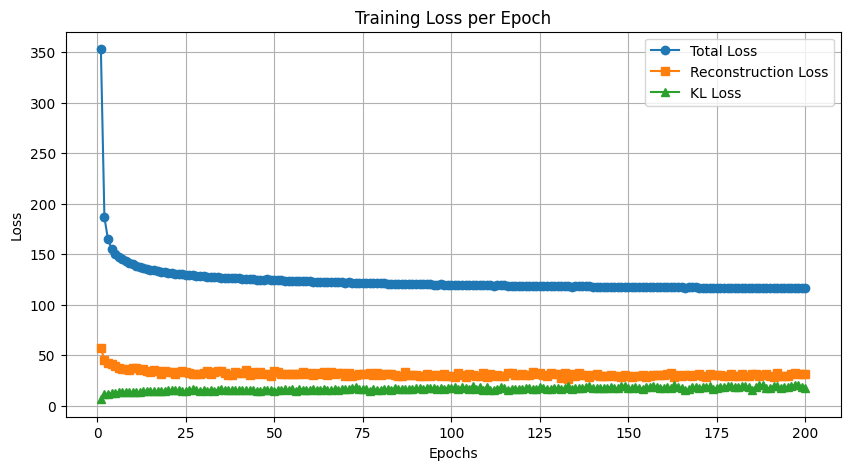

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), avg_losses, label="Total Loss", marker="o")
plt.plot(range(1, num_epochs + 1), recon_losses, label="Reconstruction Loss", marker="s")
plt.plot(range(1, num_epochs + 1), kl_losses, label="KL Loss", marker="^")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Evaluate

In [15]:
model.eval()

with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

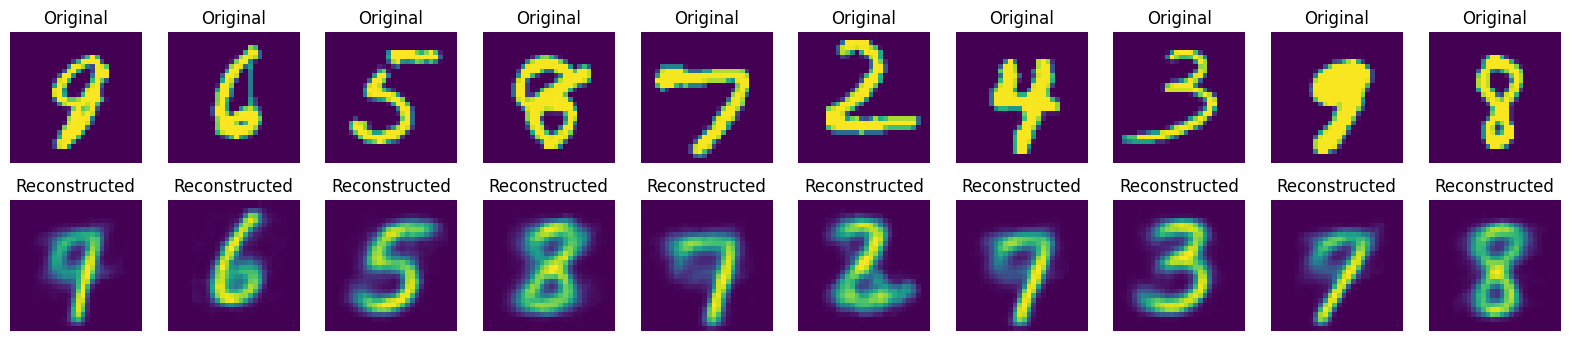

In [16]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()